# JPK AFM data analysis for liquid samples

## Import libraries
Run this ONLY ONCE. Always restart kernel before running.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib nbagg

import sys
import os
import numpy as np
import pandas as pd
from datetime import datetime
from igor import binarywave
from PyQt5.QtWidgets import QApplication, QFileDialog, QListView, QTreeView, QAbstractItemView
#from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
import wetting#, surfevol

app = QApplication(sys.argv)
plt.close('all')

#function to select multiple folders from dialog
def get_directories(caption=""):
    file_dialog = QFileDialog(caption=caption)
    file_dialog.setFileMode(QFileDialog.DirectoryOnly)
    file_dialog.setOption(QFileDialog.DontUseNativeDialog, True)
    file_view = file_dialog.findChild(QListView, 'listView')

    if file_view:
        file_view.setSelectionMode(QAbstractItemView.MultiSelection)
    f_tree_view = file_dialog.findChild(QTreeView)
    if f_tree_view:
        f_tree_view.setSelectionMode(QAbstractItemView.MultiSelection)

    if file_dialog.exec():
        paths = file_dialog.selectedFiles()
    else:
        paths = []

    return paths

#recognize if *.ibw file contains image data or force data
def categorize_ibw(filepath):
    ibw = binarywave.load(filepath)
    wdata = ibw["wave"]["wData"]
    meta_keys = []
    for line in str(ibw["wave"]["note"]).split("\\r"):
        if line.count(":"):
            key, val = line.split(":", 1)
            meta_keys.append(key)

    #CHECK THIS! MIGHT NOT WORK FOR SOME DATA
    if 'ForceDist' in meta_keys:
        file_cat = 'force'
    else:
        file_cat = 'image'
        
    return file_cat        

## Run Surface Tension code
Only works with classic Jupyter Notebook, not JupyterLab

In [96]:
%%javascript
Jupyter.notebook.execute_cells([6,8,10,12,14])

<IPython.core.display.Javascript object>

## JPK data raw files

In [97]:
jpk_file_paths, _ = QFileDialog.getOpenFileNames(caption='Select JPK data files') #JPK data (*.jpk,*.jpk-qi-data,*.jpk-force)
output_dir = ''#QFileDialog.getExistingDirectory(caption='Select output data folder') #output folder
        
#separate image data and force data files
img_file_paths = []
fd_file_paths = []
for filepath in jpk_file_paths:
    file_ext = filepath.split('.')[-1]
    if file_ext in ['jpk', 'jpk-qi-data']:
        img_file_paths.append(filepath)
    elif file_ext in ['jpk-force']:
        fd_file_paths.append(filepath)
    elif file_ext in ['ibw']: #change this
        file_cat = categorize_ibw(filepath)
        if file_cat == 'image':
            img_file_paths.append(filepath)
        elif file_cat == 'force':
            fd_file_paths.append(filepath)
        
#make output directory
if output_dir == '':
        output_dir = os.path.dirname(jpk_file_paths[0]) + '/analysis' #default "analysis" folder
output_paths = []
for img_file_path in img_file_paths:
    file_name = os.path.basename(img_file_path)
    timestamp = datetime.today().strftime('%y%m%d-%H%M%S')
    output_path = f'{output_dir}/{file_name}_results_{timestamp}'
    os.makedirs(output_path, exist_ok=True)
    output_paths.append(output_path)

print('Image data:\n', img_file_paths, '\nForce data:\n', fd_file_paths, '\nOutput folder:\n', output_paths)

Image data:
 ['/home/pranav/Work/Data/AFM Surface Tension/20221023 glycerol_mica_RFESPA_pegbrush/save_area4-2022.10.23-20.32.25.054.jpk'] 
Force data:
 ['/home/pranav/Work/Data/AFM Surface Tension/20221023 glycerol_mica_RFESPA_pegbrush/force-save_area4_drops-2022.10.23-20.46.37.645.jpk-force', '/home/pranav/Work/Data/AFM Surface Tension/20221023 glycerol_mica_RFESPA_pegbrush/force-save_area4_drops-2022.10.23-20.49.01.839.jpk-force'] 
Output folder:
 ['/home/pranav/Work/Data/AFM Surface Tension/20221023 glycerol_mica_RFESPA_pegbrush/analysis/save_area4-2022.10.23-20.32.25.054.jpk_results_230516-113219']


## AFM image

Image file: /home/pranav/Work/Data/AFM Surface Tension/20221023 glycerol_mica_RFESPA_pegbrush/save_area4-2022.10.23-20.32.25.054.jpk
Output folder: /home/pranav/Work/Data/AFM Surface Tension/20221023 glycerol_mica_RFESPA_pegbrush/analysis/save_area4-2022.10.23-20.32.25.054.jpk_results_230516-113219


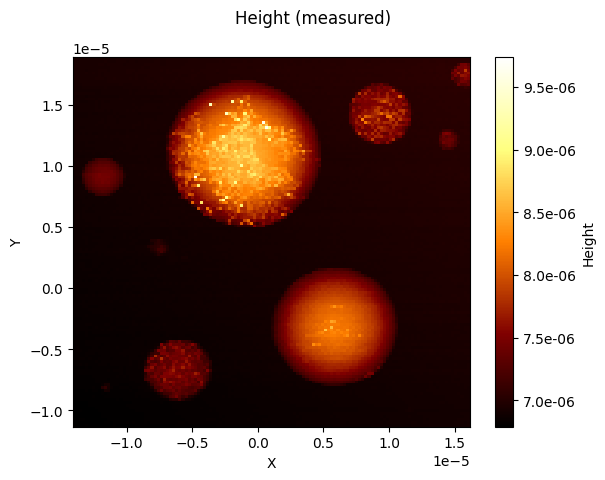

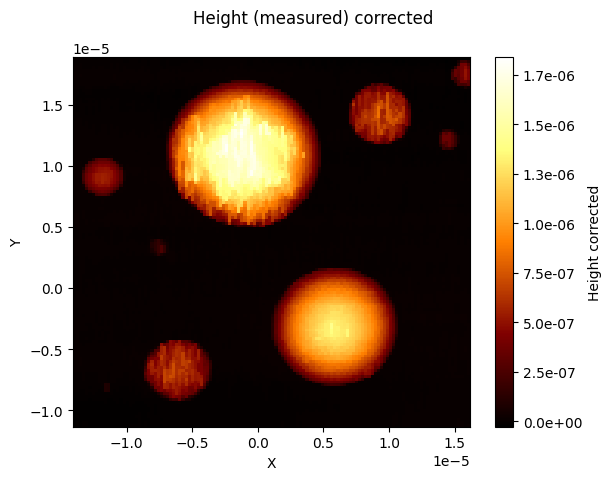

In [98]:
plt.close('all')
for img_file_path, output_path in zip(img_file_paths, output_paths):
    print('Image file:', img_file_path)
    print('Output folder:', output_path)
    afm_data, anal_data_h, fig_list =  wetting.get_afm_image(img_file_path, output_path, 
                                                             level_order=2, jump_tol=0.9,
                                                             denoise_size=5)
    for fig in fig_list:
        display(fig)

plt.close('all')

## Get liquid drop properties

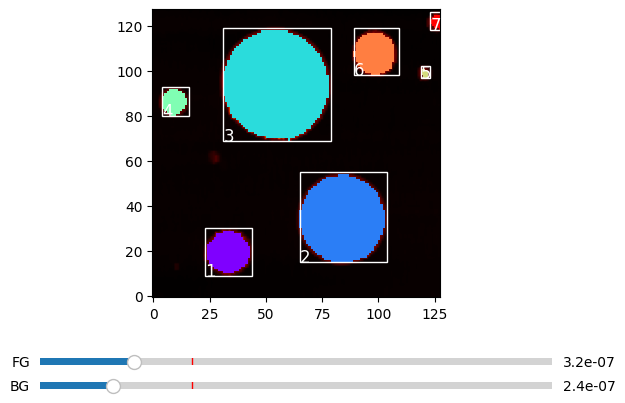

,Label,Curvature,Contact Radius,Max Height,Max Height raw,Volume,Volume raw,Drop contact angle,s,R/d,AFM file
0,1,9.700921e-06,3.491020e-06,6.499186e-07,7.204510e-07,1.258555e-17,8.838717e-18,21.091896,1.442983e-06,5.371473,/home/pranav/Work/Data/AFM Surface Tension/202...
1,2,1.102470e-05,5.235095e-06,1.322238e-06,1.418718e-06,5.813218e-17,5.546899e-17,28.349692,2.403123e-06,3.959270,/home/pranav/Work/Data/AFM Surface Tension/202...
2,3,1.283474e-05,6.436708e-06,1.730716e-06,1.838134e-06,1.153494e-16,1.105040e-16,30.099731,3.019782e-06,3.719101,/home/pranav/Work/Data/AFM Surface Tension/202...
3,4,3.610909e-06,1.943138e-06,5.674115e-07,5.583956e-07,3.460965e-18,2.696274e-18,32.556430,9.383601e-07,3.424566,/home/pranav/Work/Data/AFM Surface Tension/202...
4,5,3.915775e-07,3.888571e-07,4.376549e-07,3.650081e-07,1.478446e-19,2.167725e-19,96.757723,3.280240e-07,0.888502,/home/pranav/Work/Data/AFM Surface Tension/202...
5,6,8.256508e-06,3.353001e-06,7.114892e-07,8.619747e-07,1.275338e-17,9.312364e-18,23.960328,1.449369e-06,4.712652,/home/pranav/Work/Data/AFM Surface Tension/202...
6,7,4.668669e-07,4.668269e-07,4.607545e-07,5.123457e-07,2.089414e-19,5.116085e-19,89.249838,3.681109e-07,1.013179,/home/pranav/Work/Data/AFM Surface Tension/202...


In [99]:
plt.close('all')
#drop analysis of AFM data
drop_df, img_anal, fig_list = wetting.get_drop_prop(afm_data, anal_data_h, output_paths[0])
drop_df['AFM file'] = img_file_paths[0]
for fig in fig_list:
    display(fig)
display(drop_df)
plt.close('all')

## Analyze force distance curves

Force file: /home/pranav/Work/Data/AFM Surface Tension/20221023 glycerol_mica_RFESPA_pegbrush/force-save_area4_drops-2022.10.23-20.46.37.645.jpk-force
Force file: /home/pranav/Work/Data/AFM Surface Tension/20221023 glycerol_mica_RFESPA_pegbrush/force-save_area4_drops-2022.10.23-20.49.01.839.jpk-force


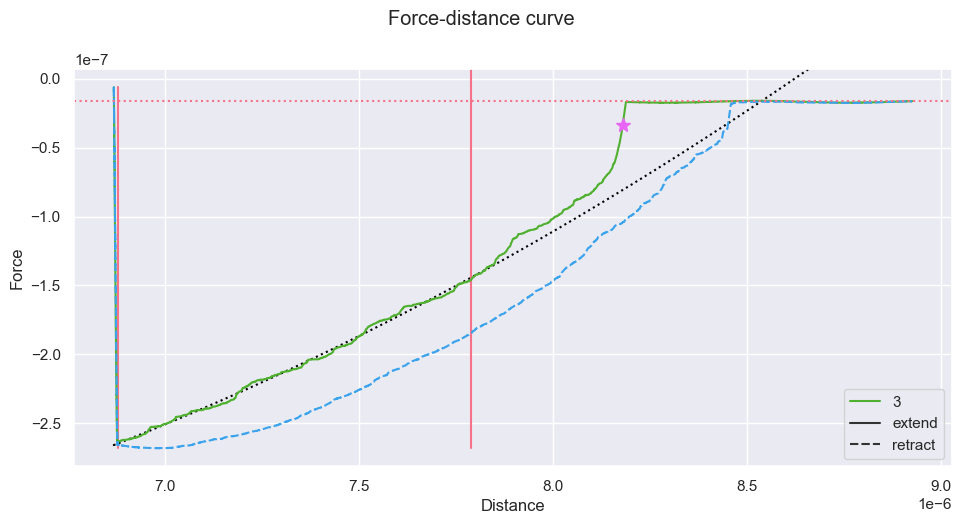

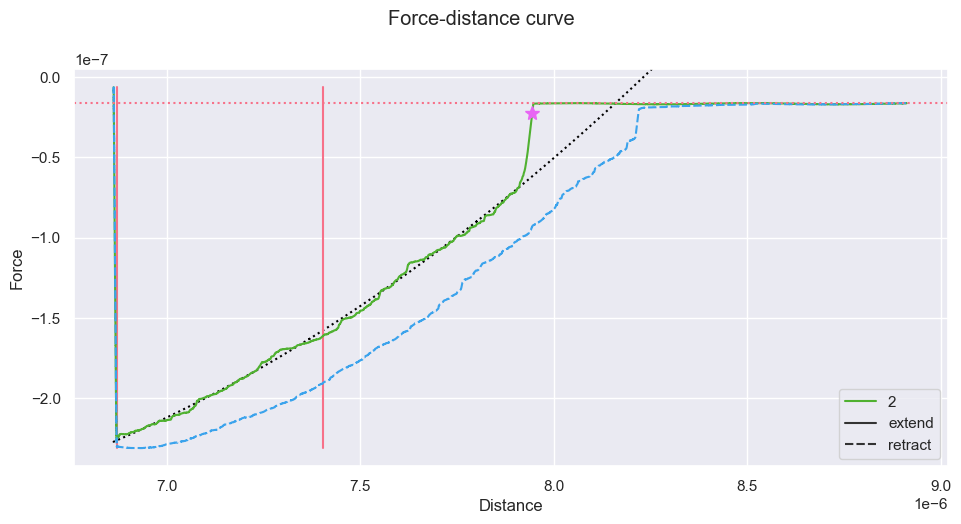

,Label,Adhesion (FD),Jumpin distance (FD),Slope (FD),Wetted length (FD),Fit distance (FD),Adhesion energy (FD),FD X position,FD Y position,FD file
0,3,2.467988e-07,0.000001,0.132163,0.000002,9.075800e-07,2.075274e-13,-0.000001,0.000011,/home/pranav/Work/Data/AFM Surface Tension/202...
1,2,2.090391e-07,0.000001,0.128513,0.000002,5.326167e-07,1.464078e-13,0.000006,-0.000004,/home/pranav/Work/Data/AFM Surface Tension/202...


In [100]:
plt.close('all')
fd_drop_df, fdfit_dict, fddata_dict, fig_list = wetting.analyze_drop_fd(fd_file_paths, afm_data, img_anal,
                                                                        force_cycle = 'approach', fit_order = 2,
                                                                        output_path = output_paths[0])

for fig in fig_list:
    #fig = Image(fig_path, width=400, height=400)
    display(fig)
display(fd_drop_df)

## Droplet surface tension calculation

Poly-fit method
Cone
       Surface Tension (fixed, mN/m)  Tip contact angle (fixed)  \
Label                                                             
3                          64.282345                         40   
2                          70.241068                         40   

       Surface Tension (polyfit, mN/m)  Tip contact angle (polyfit)  
Label                                                                
3                            77.703555                         50.0  
2                            65.331834                         35.0  
Poly-fit method
Pyramid
       Surface Tension (fixed, mN/m)  Tip contact angle (fixed)  \
Label                                                             
3                          56.212328                         40   
2                          61.054606                         40   

       Surface Tension (polyfit, mN/m)  Tip contact angle (polyfit)  
Label                                                              

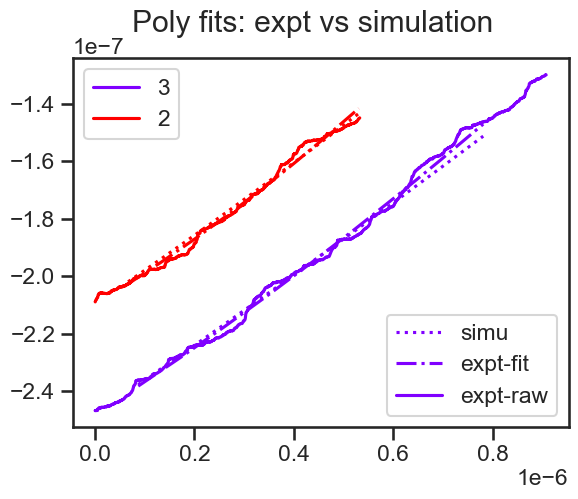

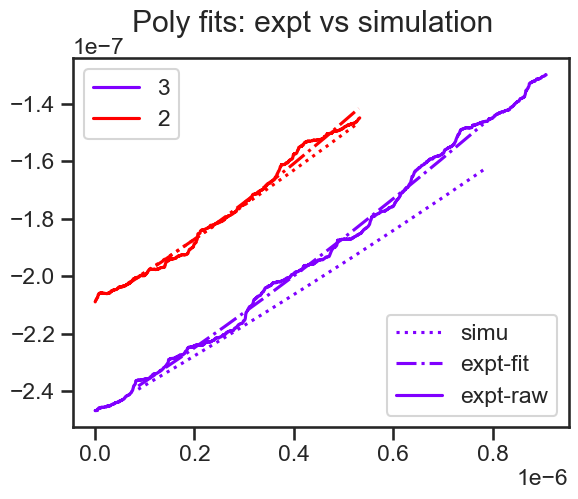

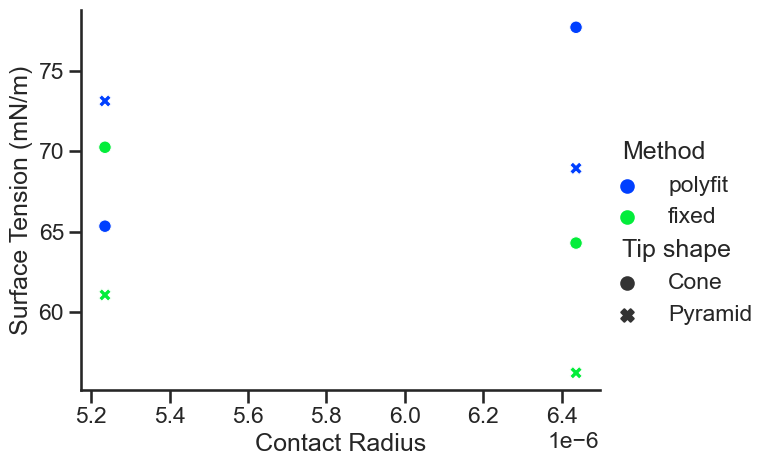

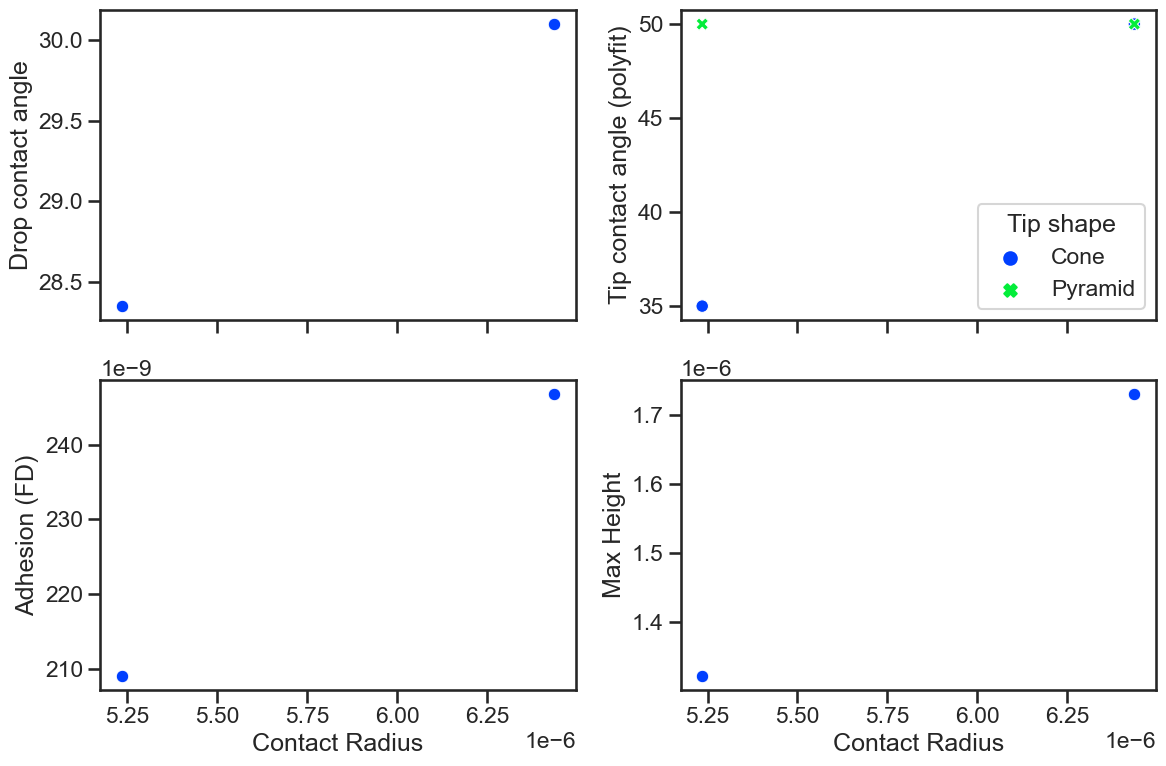

In [101]:
contact_angle = 40 #Set fixed value to calculate its corresponsing surface tension (None take average of polyfit contact angle values)
cone_a = 29 # cone angle from SEM (near tip)
pyr_a = 38 #pyramid angle from SEM

pyr_a_eff = 2*np.arctan(np.tan((pyr_a/2)*np.pi/180/2)/np.sqrt(2))*180/np.pi #effective half angle since SEM images are oriented 45
tip_angle_dict = {'Cone':int(cone_a/2), 
                  'Pyramid':int(pyr_a_eff)}

plt.close('all')
sns.set_style("ticks")
sns.set_context("talk")

#combine droplet image and force result data
afm_df = drop_df.set_index('Label').join(fd_drop_df.set_index('Label'), how='right')
    
# calculate surface tension by complete FD fitting using 2nd order poly approximation
output_df_cone2, fig_fit_cone = wetting.get_surface_tension(afm_df, 'Cone', tip_angle_dict['Cone'], 
                                               contact_angle, fdfit_dict, fddata_dict,
                                               file_path=output_paths[0], save=False)
output_df_pyr2, fig_fit_pyr = wetting.get_surface_tension(afm_df, 'Pyramid', tip_angle_dict['Pyramid'], 
                                               contact_angle, fdfit_dict, fddata_dict,
                                               file_path=output_paths[0], save=False)
output_df_polyfit = output_df_cone2.append(output_df_pyr2)
afm_filename = output_df_polyfit['AFM file'].iloc[0].split('/')[-1][:-4]
output_df_polyfit.to_excel(f'{output_paths[0]}/output_final-{afm_filename}.xlsx')

#display fitting plots
display(fig_fit_cone)
fig_fit_cone.savefig(f'{output_paths[0]}/cone_polyfit_result.png', bbox_inches = 'tight',
            transparent = False)
display(fig_fit_pyr)
fig_fit_pyr.savefig(f'{output_paths[0]}/pyramid_polyfit_result.png', bbox_inches = 'tight',
            transparent = False)
plt.close('all')

#plot surface tension results
output_df_polyfit_reshaped = pd.melt(output_df_polyfit[['Tip shape','Contact Radius','Surface Tension (polyfit, mN/m)','Surface Tension (fixed, mN/m)']], 
                                     id_vars=['Tip shape','Contact Radius'],
                                    value_vars=['Surface Tension (polyfit, mN/m)','Surface Tension (fixed, mN/m)'],
                                    var_name='Method', value_name='Surface Tension (mN/m)')
output_df_polyfit_reshaped.replace({'Method': {'Surface Tension (polyfit, mN/m)': 'polyfit', 
                                               'Surface Tension (fixed, mN/m)': 'fixed'}}, inplace=True)
g1 = sns.relplot(data=output_df_polyfit_reshaped, x="Contact Radius", 
                      y="Surface Tension (mN/m)",
                     style="Tip shape",hue="Method",
                     kind='scatter', aspect=1.3)
#show and save plot
fig1 = g1.figure
display(fig1)
fig1.savefig(f'{output_paths[0]}/surface_tension.png', bbox_inches = 'tight',
             transparent = False)


plot_vars = ['Drop contact angle','Tip contact angle (polyfit)',
             'Adhesion (FD)', 'Max Height']

fig2, ax2 = plt.subplots(2, 2, sharex=True, figsize=(12, 8))
sns.scatterplot(data=output_df_polyfit, x="Contact Radius",
                y=plot_vars[0], ax=ax2[0,0])
sns.scatterplot(data=output_df_polyfit, x="Contact Radius",
                y=plot_vars[1], style="Tip shape", hue="Tip shape", ax=ax2[0,1])
sns.scatterplot(data=output_df_polyfit, x="Contact Radius",
                y=plot_vars[2], ax=ax2[1,0])
sns.scatterplot(data=output_df_polyfit, x="Contact Radius",
                y=plot_vars[3], ax=ax2[1,1])

#number formatting
ax2[1][0].ticklabel_format(axis='y', style='sci', scilimits=(-9,-9))
ax2[1][1].ticklabel_format(axis='y', style='sci', scilimits=(-6,-6))
ax2[1][1].ticklabel_format(axis='x', style='sci', scilimits=(-6,-6))
fig2.tight_layout()
display(fig2)
fig2.savefig(f'{output_paths[0]}/other_results.png', bbox_inches = 'tight',
             transparent = False)

plt.close('all')

## Combine results from different folders

In [2]:
plt.cla()
plt.clf()
plt.close('all')
folder_paths = get_directories("Select analysis result folder (containing output Excel file)")
summary_df = wetting.combine_result_spreadsheets(folder_paths)

summary_df['Liquid'] = 'Glycerol' #SET THIS!
summary_df['DQ'] = 'Y' #CHANGE to N manually if data not good
summary_df = summary_df[summary_df['FD file'] != '']

summary_df.rename(columns={"Max Height": "Drop Height (m)"}, inplace=True)
#summary_df = summary_df[summary_df[surf_ten_label] != 0]
#summary_df.replace(0, np.nan, inplace=True)
timestamp = datetime.today().strftime('%y%m%d-%H%M%S')
output_dir2 = os.path.dirname(folder_paths[-1])
#dir_name = os.path.basename(folder_paths[-1]) # use this to use same name as source folder name
dir_name = os.path.basename(os.path.dirname(output_dir2))
summary_df.to_excel(f'{output_dir2}/summary_data_{dir_name}_{timestamp}.xlsx', index=None)


#plot surface tension results
x_var = "Drop Height (m)"# "Contact Radius",'Liquid','R square (polyfit)',
val_vars = ['Surface Tension (polyfit, mN/m)','Surface Tension (fixed, mN/m)']
id_vars = [p for p in list(summary_df.columns) if p not in val_vars]
cols = summary_df.columns
summary_df_reshaped = pd.melt(summary_df, 
                                     id_vars=id_vars,
                                    value_vars=val_vars,
                                    var_name='Method', value_name='Surface Tension (mN/m)')
summary_df_reshaped.replace({'Method': {'Surface Tension (polyfit, mN/m)': 'polyfit', 
                                        'Surface Tension (fixed, mN/m)': 'fixed'}}, inplace=True)
#summary_df_reshaped = summary_df_reshaped[summary_df_reshaped['Method'] == 'fixed'] #CHECK
#summary_df_reshaped = summary_df_reshaped[summary_df_reshaped['DQ'] == 'Y'] #CHECK

# #summary_df_reshaped = summary_df_reshaped[summary_df_reshaped['R square (polyfit)'] > 0.9]
# #summary_df_reshaped = summary_df_reshaped[summary_df_reshaped['Tip shape'] == 'Cone']
#group data by tip shape to get average surface tension
# summary_df_reshaped = summary_df_reshaped[['Drop Height (m)','Liquid','Tip shape',
#                                            'Surface Tension (mN/m)']]
# summary_df_reshaped = summary_df_reshaped.groupby(['Drop Height (m)','Liquid']).mean()

#generate pivot table to summarize surface tension for fixed contact angle
summary_final = pd.pivot_table(summary_df_reshaped[summary_df_reshaped['Method'] == 'fixed'], 
                               values=['Surface Tension (mN/m)'], 
                               index=['Liquid','Tip shape'],
                               aggfunc={'Surface Tension (mN/m)': [np.mean, np.std]})
summary_final.to_excel(f'{output_dir2}/summary_final_{dir_name}_{timestamp}.xlsx')
display(summary_final)

g3 = sns.relplot(data=summary_df_reshaped, x=x_var,
                y="Surface Tension (mN/m)", hue="Method", #Method, Liquid CHECK
                style="Tip shape",
                style_order=['Cone','Pyramid'],
                kind='scatter', aspect=1.3)

#ax.ticklabel_format(axis='x', style='sci', scilimits=(-6,-6))
#show and save plot
fig3 = g3.figure
fig3.savefig(f'{output_dir2}/summary_plot_{dir_name}_{timestamp}.png', bbox_inches = 'tight',
            transparent = False)
display(fig3)

plot_vars = ['Drop contact angle','Tip contact angle (polyfit)',
             'Adhesion (FD)', 'Drop Height (m)']

fig4, ax4 = plt.subplots(2, 2, sharex=True, figsize=(12, 8))
sns.scatterplot(data=summary_df, x=x_var,
                y=plot_vars[0], ax=ax4[0,0])
sns.scatterplot(data=summary_df, x=x_var,
                y=plot_vars[1], style="Tip shape", 
                hue="Liquid", 
                ax=ax4[0,1])
sns.scatterplot(data=summary_df, x=x_var,
                y=plot_vars[2], ax=ax4[1,0])
sns.scatterplot(data=summary_df, x=x_var,
                y=plot_vars[3], ax=ax4[1,1])

#number formatting
ax4[1][0].ticklabel_format(axis='y', style='sci', scilimits=(-9,-9))
ax4[1][1].ticklabel_format(axis='y', style='sci', scilimits=(-6,-6))
ax4[1][1].ticklabel_format(axis='x', style='sci', scilimits=(-6,-6))
fig4.tight_layout()
display(fig4)
fig4.savefig(f'{output_dir2}/summary_other_results_{dir_name}_{timestamp}.png', bbox_inches = 'tight',
             transparent = False)

display(summary_df)
plt.close('all')

KeyError: 'Drop Height (m)'

## Combine multiple FD curves

In [3]:
plt.close('all')
# combine multiple fd curves
output_path = ''
fd_file_paths, _ = QFileDialog.getOpenFileNames()
wetting.combine_fd(fd_file_paths, zero_shift=True, 
                   output_dir=output_path,save=False)
#wetting.get_adhesion_from_fd(fd_file_paths)

-5.4889962514475184e-08
-5.501130255304605e-08
-5.3821966434322734e-08


## Optional codes

In [ ]:
# calculate contact angle from fd curve
label = 5 #INPUT
label_df = drop_df[drop_df['Label']==label]
s = label_df['s'].iloc[0]
R = round(label_df['R/s'].iloc[0])
contact_angle = wetting.get_contact_angle(fd_file_paths[0], simu_df,
                                         R, s, fit_index=5000)

